In [2]:
"""
Use this  notebook to calcualte heat budget at one point in Indian ocean. 
Perform timeseries anlaysis on the point and see hwo heat budget looks. 
This is to ensure that the units and magnitude are correct
"""

'\nUse this  notebook to calcualte heat budget at one point in Indian ocean. \nPerform timeseries anlaysis on the point and see hwo heat budget looks. \nThis is to ensure that the units and magnitude are correct\n'

In [3]:
#Import required modules
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import glob as glob

In [97]:
#load in whole dataset

EC_Earth3_dir = '/g/data/e14/sm2435/CMIP6/EC-Earth3/'
#load in all full DS to get climatology
U=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'UO/*.nc' ))
V=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'VO/*.nc' ))
W=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'WO/*.nc' ))
T=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'THETAO/*.nc' ))

/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future defaul

In [66]:
#define function to calcualte Anomlay and climatology 
def get_clim(DS):
    #calc climatology
    clim = DS.groupby('time.month').mean('time')
    ANOM = DS.groupby('time.month') - clim
    return ANOM, clim


In [98]:
#restrict data down to 9 gridcell block
U = U.sel(lat=slice(-10,-7),lon=slice(97,100))
V = V.sel(lat=slice(-10,-7),lon=slice(97,100))
W = W.sel(lat=slice(-10,-7),lon=slice(97,100))
T = T.sel(lat=slice(-10,-7),lon=slice(97,100))
#get W coords in same type as others
W = W.assign_coords(lev = T.lev)

In [99]:
#now get anomaly and climatology terms for each variable
ua, ubar = get_clim(U.uo)
va, vbar = get_clim(V.vo)
wa, wbar = get_clim(W.wo)
ta, tbar = get_clim(T.thetao)

In [133]:
#need to rechunk 'ta' array so that it can be differentiated. then calc deriviatives 
dTdt = T.thetao.chunk(1980, 20,3,3).differentiate(coord = 'time',datetime_unit= 's')
dTdx = ta.differentiate('lon') / (110e3 * np.cos(ta.lat * np.pi / 180))
dTdy = ta.differentiate('lat') / 110e3 
dTdz = ta.differentiate('lev')
#climatological values
dTbardx = tbar.differentiate('lon') / (110e3 * np.cos(tbar.lat * np.pi / 180))
dTbardy = tbar.differentiate('lat') / 110e3
dTbardz = tbar.differentiate('lev')


In [135]:
#now get U advection terms, need to ensure data is coreectly goruped to add together
udTdx = ua*dTdx
ubardTdx = ubar*dTdx.groupby('time.month')
udtbardx = ua.groupby('time.month')*dTbardx
#get v
vdTdy = va*dTdy
vbardTdy = vbar*dTdy.groupby('time.month')
vdtbardy = va.groupby('time.month')*dTbardy
#get w
wdTdz = wa*dTdz
wbardTdz = wbar*dTdz.groupby('time.month')
wdtbardz = wa.groupby('time.month')*dTbardz

In [136]:
#now extract central point of each of these terms
udTdx = udTdx[:,:,1,1]
ubardTdx = ubardTdx[:,:,1,1]
udtbardx = udtbardx[:,:,1,1]
#get v
vdTdy = vdTdy[:,:,1,1]
vbardTdy = vbardTdy[:,:,1,1]
vdtbardy = vdtbardy[:,:,1,1]
#get w
wdTdz = wdTdz[:,:,1,1]
wbardTdz = wbardTdz[:,:,1,1]
wdtbardz = wdtbardz[:,:,1,1]
#
dTdt = dTdt[:,:,1,1]

In [137]:
#now integrate through levels to get 2d timeseries at point
udTdx_i = udTdx.integrate('lev')
ubardTdx_i = ubardTdx.integrate('lev')
udtbardx_i = udtbardx.integrate('lev')

vdTdy_i = vdTdy.integrate('lev')
vbardTdy_i = vbardTdy.integrate('lev')
vdtbardy_i = vdtbardy.integrate('lev')

wdTdz_i = wdTdz.integrate('lev')
wbardTdz_i = wbardTdz.integrate('lev')
wdtbardz_i = wdtbardz.integrate('lev')

dTdt_i = dTdt.integrate('lev')

In [104]:
#load in q and get qnet
Q = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/EC-Earth3_HFDS.nc')

In [105]:
#get qnet and subset
qpch = (Q.hfds/(3986*1026*61.11283875)).sel(lat=slice(-20,-17),lon=slice(97,100))[:,1,1]

In [106]:
qpch

<xarray.DataArray 'hfds' (time: 1980)>
array([ 3.5312496e-07,  2.8254991e-07,  9.8524637e-08, ...,
       -1.4865688e-07,  6.3077984e-08,  1.6733800e-07], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    lon      float64 98.5
    lat      float64 -18.5

In [107]:
#now we have all terms. We can plot timeseries together
#make advection terms
uadv = udtbardx_i+udTdx_i+ubardTdx_i
vadv = vdtbardy_i+vdTdy_i+vbardTdy_i
wadv = wdtbardz_i+wdTdz_i+wbardTdz_i

In [16]:
#select 2 years of data. 1997-1998


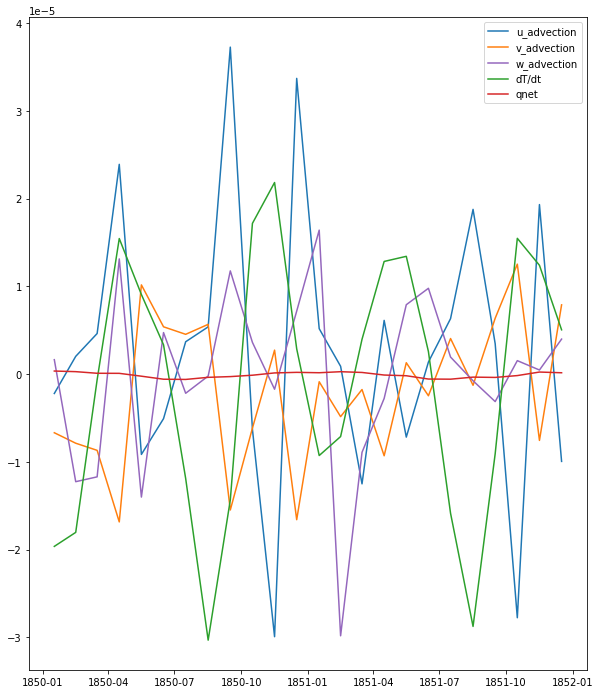

In [139]:
plt.figure(figsize = (10,12))
plt.plot(uadv.time[0:24], uadv[0:24], c = 'tab:blue', label = 'u_advection')
plt.plot(vadv.time[0:24], vadv[0:24], c = 'tab:orange', label = 'v_advection')
plt.plot(wadv.time[0:24], wadv[0:24], c = 'tab:purple', label = 'w_advection')

plt.plot(dTdt_i.time[0:24], dTdt_i[0:24], c = 'tab:green', label = 'dT/dt')
plt.plot(qpch.time[0:24], qpch[0:24], c = 'tab:red', label = 'qnet')
plt.legend()

In [138]:
dTdt_i.load()
uadv.load()
vadv.load()
wadv.load()
qpch.load()

<xarray.DataArray 'thetao' (time: 1980)>
array([-1.96361976e-05, -1.80394094e-05, -6.46170393e-07, ...,
        3.24386558e-06,  1.44926862e-05,  1.19564343e-05])
Coordinates:
    lat      float64 -8.5
    lon      float64 98.5
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00

In [109]:
qpch.load()

<xarray.DataArray 'hfds' (time: 1980)>
array([ 3.5312496e-07,  2.8254991e-07,  9.8524637e-08, ...,
       -1.4865688e-07,  6.3077984e-08,  1.6733800e-07], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    lon      float64 98.5
    lat      float64 -18.5

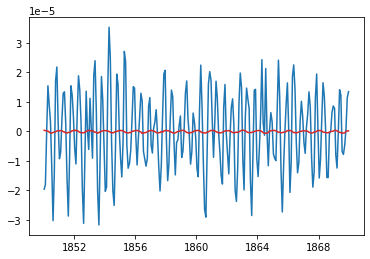

In [140]:
plt.figure()
plt.plot(dTdt_i.time[0:240], dTdt_i[0:240])
plt.plot(qpch.time[0:240], qpch[0:240], c = 'tab:red', label = 'qnet')


In [127]:
resid = dTdt_i +uadv+vadv+wadv-qpch

In [128]:
resid_M = resid.groupby('time.month').mean('time')

In [83]:
dTdt_i.integrate('time').values

array(1.58381152e+10)

In [141]:
#get monthly budgets of each term
dTdt_i_M = dTdt_i.groupby('time.month').mean('time')
qpch_M = qpch.groupby('time.month').mean('time')
uadv_M = uadv.groupby('time.month').mean('time')
vadv_M = vadv.groupby('time.month').mean('time')
wadv_M = wadv.groupby('time.month').mean('time')
qpch_M = qpch.groupby('time.month').mean('time')

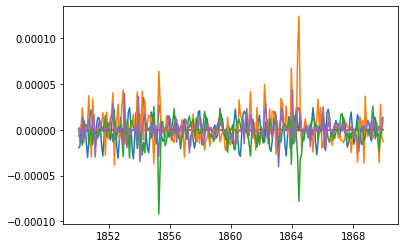

In [142]:
plt.figure()
plt.plot(dTdt_i.time[0:240], dTdt_i[0:240], c = 'tab:blue', label = 'dT/dt')
plt.plot(qpch.time[0:240], qpch[0:240], c = 'tab:red', label = 'qnet')
plt.plot(uadv.time[0:240], uadv[0:240], c = 'tab:orange', label = 'uadv')
plt.plot(vadv.time[0:240], vadv[0:240], c = 'tab:green', label = 'vadv')
plt.plot(wadv.time[0:240], wadv[0:240], c = 'tab:purple', label = 'wadv')

In [115]:
TERMS = qpch - uadv - vadv - wadv

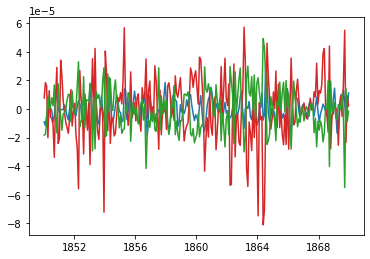

In [117]:
plt.figure()
plt.plot(dTdt_i.time[0:240], dTdt_i[0:240], c = 'tab:blue', label = 'dT/dt')
plt.plot(TERMS.time[0:240], TERMS[0:240], c = 'tab:red', label = 'sum')
plt.plot(res.time[0:240], res[0:240], c = 'tab:green', label = 'sum')

In [124]:
res = dTdt_i -TERMS


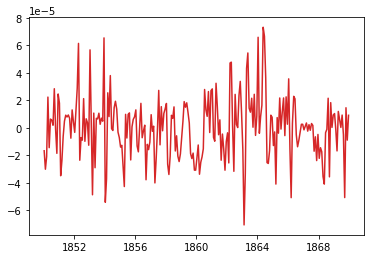

In [119]:
plt.plot(res.time[0:240], res[0:240], c = 'tab:red', label = 'sum')

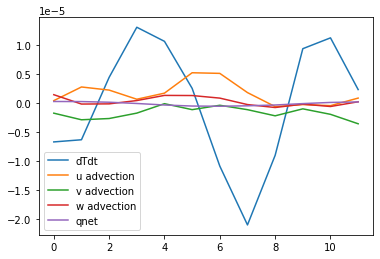

In [150]:
plt.figure()
plt.plot(dTdt_i_M, label = 'dTdt')
#plt.plot(uadv_M+vadv_M+wadv_M, label = 'advcetion')
plt.plot(uadv_M, label = 'u advection')
plt.plot(vadv_M, label = 'v advection')
plt.plot(wadv_M, label = 'w advection')
plt.plot(qpch_M, label = 'qnet')
#plt.plot(resid_M, label = 'residual')
plt.legend()

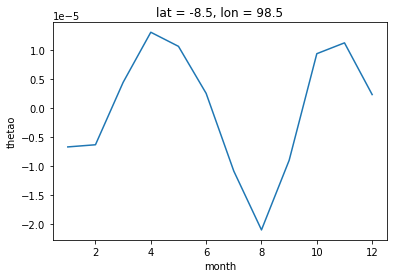

In [149]:
dTdt_i.groupby('time.month').mean().plot()

In [96]:
W = W.assign_coords(lev = T.lev)

,Array,Chunk
Bytes,31.68 kB,192 B
Shape,"(1980, 2)","(12, 2)"
Count,495 Tasks,165 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,633.60 kB,3.84 kB
Shape,"(1980, 20, 2)","(12, 20, 2)"
Count,662 Tasks,165 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [151]:
for i in T.time:
    dTdt = (T[i+2]-T[i])/(2*60*60*24*30)

TypeError: iteration over a 0-d array

KeyError: 0

In [ ]:
T=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'THETAO/*.nc' ))